In [11]:
!nvidia-smi

Fri Feb 27 00:11:49 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070        Off |   00000000:01:00.0  On |                  N/A |
| 60%   50C    P0             35W /  250W |     906MiB /  12227MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
from download_model import download_model
from constants import MODEL_DIR, MODEL_NAME

In [ ]:
download_model(MODEL_NAME, MODEL_DIR)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

In [3]:
download_model("Qwen/Qwen2.5-1.5B", "model-1.5b")

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

- __+1 point__ you can perform forward pass with offloading on *some* input sequence (any batch size / length)


In [11]:
!python run_model.py

preparing model for offloading: 100%|███████████| 28/28 [00:28<00:00,  1.01s/it]
forward: (128, 1024), micro_batch_size=8
33.48s (3915 tokens/s)
max memory allocated: 7.17GB


- __+1 point__ check that forward pass with offloading is `torch.allclose` to forward pass without offloading
    - since you (likely) can't run the full model w/o offloading, test it the 1.3B model from earlier

In [8]:
!pytest tests/test_offloaded_model.py

============================= test session starts ==============================
platform linux -- Python 3.11.14, pytest-9.0.2, pluggy-1.6.0
rootdir: /home/l0ver1ck/repos/ysda/efficient-dl-systems/week04_large_models
configfile: pyproject.toml
plugins: anyio-4.12.1
collected 1 item                                                               

tests/test_offloaded_model.py .                                          [100%]

========================= 1 passed in 63.64s (0:01:03) =========================


- __+1 point__ you can perform forward pass on 128x1024 tokens of actual text data (e.g. the sample data above)


In [10]:
!pytest tests/test_big_batch.py

============================= test session starts ==============================
platform linux -- Python 3.11.14, pytest-9.0.2, pluggy-1.6.0
rootdir: /home/l0ver1ck/repos/ysda/efficient-dl-systems/week04_large_models
configfile: pyproject.toml
plugins: anyio-4.12.1
collected 1 item                                                               

tests/test_big_batch.py .                                                [100%]

======================== 1 passed in 159.83s (0:02:39) =========================


- __+1 point__ you can compute gradients with offloading on the same 128x1024 tokens from the real text data


In [4]:
!pytest -s tests/test_backward.py

============================= test session starts ==============================
platform linux -- Python 3.11.14, pytest-9.0.2, pluggy-1.6.0
rootdir: /home/l0ver1ck/repos/ysda/efficient-dl-systems/week04_large_models
configfile: pyproject.toml
plugins: anyio-4.12.1
collected 1 item                                                               

preparing model for offloading: 100%|███████████| 28/28 [00:26<00:00,  1.04it/s]
trainable params: 2,523,136 || all params: 1,092,851,200 || trainable%: 0.2309
training on input_ids.shape=torch.Size([128, 1024]), NUM_STEPS=10, MICRO_BATCH=2
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
step=0: total_loss=11.528596848249435  (elapsed=146.09137654304504s)
step=1: total_loss=11.480492144823074  (elapsed=145.61134219169617s)
step=2: total_loss=11.460137382149696  (elapsed=145.4983732700348s)
step=3: total_loss=11.445397093892097  (elapsed=145.4304187297821s)
step=4: total_loss=11.384914562106133  (elapse

- __+1 point__ you can inference the model - and it generates some human-readable text


In [9]:
!pytest -s tests/test_generate.py

============================= test session starts ==============================
platform linux -- Python 3.11.14, pytest-9.0.2, pluggy-1.6.0
rootdir: /home/l0ver1ck/repos/ysda/efficient-dl-systems/week04_large_models
configfile: pyproject.toml
plugins: anyio-4.12.1
collected 1 item                                                               

preparing model for offloading: 100%|███████████| 28/28 [00:26<00:00,  1.05it/s]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.

Tony is talking to Darth Vader. 
Tony is a german kid that likes ice cream and computer games. 
Darth Vader is a sith lord that likes killing jedi and breathing heavily.

Tony:  Hey, Darth Vader! How's it going?

Darth Vader:  (breathing heavily) I am well, young one. And you?

Tony:  I'm doing great! I just finished playing my favorite computer game. It's so
.

======================== 1 passed in 109.38s (0:01:49) =========================


- **Prefetch offloaded layers (2pt):** optimize your code so that it begins pre-loading the next offloaded layer in the background, while computing the current layer. It can be done with a copy with non_blocking=True, or, for fine-grained control, CUDA streams. To get the full grade for this assignment, please demonstrate that your approach is faster than naive offloading, at least during large batch forward/backward pass. This can be done using a profiler.

In [6]:
!python benchmark.py

benchmark: input (16, 1024), MICRO_BATCH=8, N_REPEATS=3

preparing model for offloading: 100%|███████████| 28/28 [00:30<00:00,  1.08s/it]
With prefetch:    4.23s
/home/l0ver1ck/repos/ysda/.venv/lib/python3.11/site-packages/torch/profiler/profiler.py:217: UserWarning: Warning: Profiler clears events at the end of each cycle.Only events from the current cycle will be reported.To keep events across cycles, set acc_events=True.
  _warn_once(
without prefetch: 4.60s


trace naive

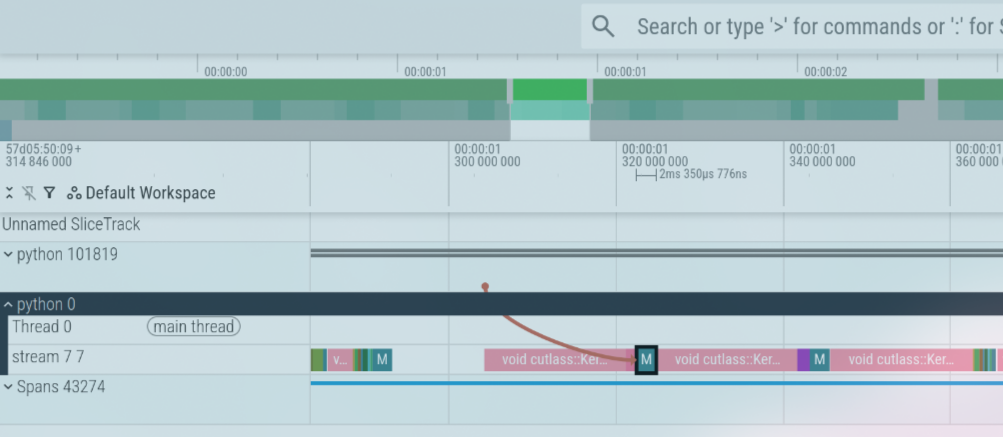

trace prefetch

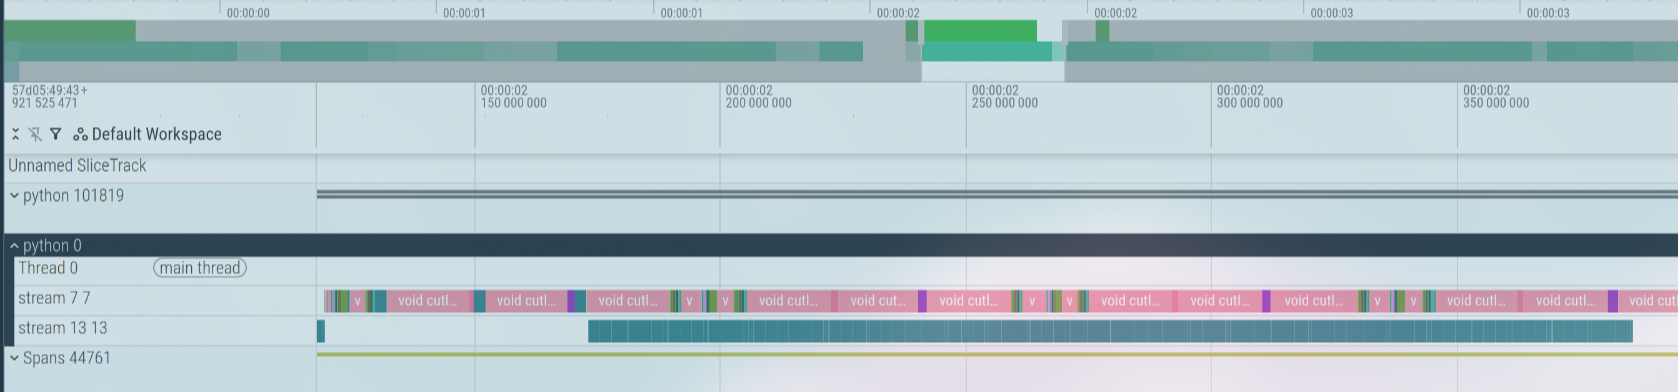